In [1]:
!nvidia-smi -L

!git clone https://github.com/levindabhi/stylegan2-pytorch.git
%cd /content/stylegan2-pytorch

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-32d1d33e-e52d-3521-5cd6-ad74c98797f1)
Cloning into 'stylegan2-pytorch'...
remote: Enumerating objects: 383, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 383 (delta 3), reused 9 (delta 3), pack-reused 372
Receiving objects: 100% (383/383), 122.51 MiB | 24.49 MiB/s, done.
Resolving deltas: 100% (190/190), done.
/content/stylegan2-pytorch


In [2]:
# Select a weight from here
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/

import gdown, os

url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/afhqdog.pkl'
output_path = 'afhqdog.pkl'
if not os.path.exists(output_path):
    gdown.download(url, output_path, quiet=False)

!git clone https://github.com/NVlabs/stylegan2-ada.git

Downloading...
From: https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/afhqdog.pkl
To: /content/stylegan2-pytorch/afhqdog.pkl
100%|██████████| 364M/364M [00:02<00:00, 158MB/s]


Cloning into 'stylegan2-ada'...
remote: Enumerating objects: 71, done.
remote: Total 71 (delta 0), reused 0 (delta 0), pack-reused 71
Unpacking objects: 100% (71/71), done.


In [3]:
!pip install ninja

     |████████████████████████████████| 112kB 14.9MB/s 


TensorFlow 1.x selected.
Setting up TensorFlow plugin "fused_bias_act.cu": Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Compiling... Loading... Done.


/content/stylegan2-pytorch/op/conv2d_gradfix.py:89: UserWarning: conv2d_gradfix not supported on PyTorch 1.9.0+cu102. Falling back to torch.nn.functional.conv2d().
  f"conv2d_gradfix not supported on PyTorch {torch.__version__}. Falling back to torch.nn.functional.conv2d()."


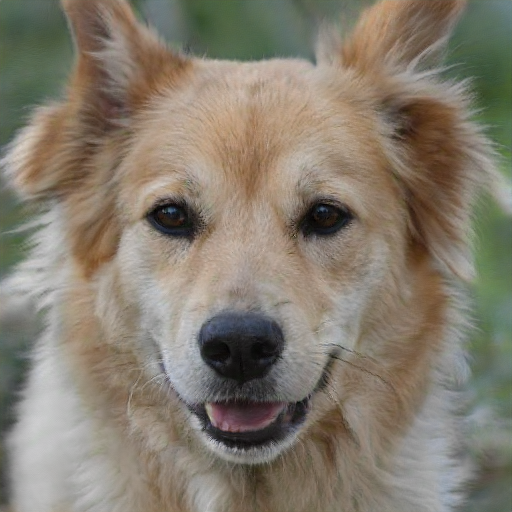

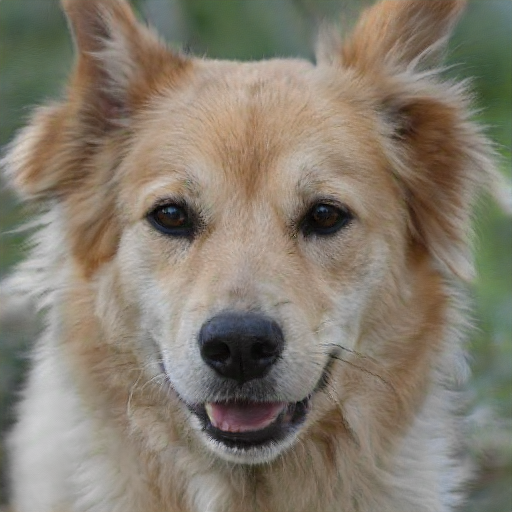

In [4]:
%tensorflow_version 1.x
import PIL 
from PIL import Image

import argparse
import os
import sys
import pickle
import math

import torch
import numpy as np
from torchvision import utils

from model import Generator, Discriminator
from convert_weight import convert_modconv, convert_conv, convert_torgb, convert_dense, update, discriminator_fill_statedict, fill_statedict

class parser():
    def __init__(self):
        self.repo = 'stylegan2-ada'
        self.gen = False
        self.disc = False
        self.channel_multiplier = 2
        self.path = None

args = parser()

args.repo = 'stylegan2-ada'
args.gen = True
args.disc = True
args.path = output_path
sys.path.append(args.repo)

import dnnlib
from dnnlib import tflib

tflib.init_tf()

with open(args.path, "rb") as f:
    generator, discriminator, g_ema = pickle.load(f)
    Gs = g_ema
    _D = discriminator
    _G = generator

size = g_ema.output_shape[2]

n_mlp = 0
mapping_layers_names = g_ema.__getstate__()['components']['mapping'].list_layers()
for layer in mapping_layers_names:
    if layer[0].startswith('Dense'):
        n_mlp += 1

g = Generator(size, 512, n_mlp, channel_multiplier=args.channel_multiplier)
state_dict = g.state_dict()
state_dict = fill_statedict(state_dict, g_ema.vars, size, n_mlp)

g.load_state_dict(state_dict)

latent_avg = torch.from_numpy(g_ema.vars["dlatent_avg"].value().eval())

ckpt = {"g_ema": state_dict, "latent_avg": latent_avg}

if args.gen:
    g_train = Generator(size, 512, n_mlp, channel_multiplier=args.channel_multiplier)
    g_train_state = g_train.state_dict()
    g_train_state = fill_statedict(g_train_state, generator.vars, size, n_mlp)
    ckpt["g"] = g_train_state

if args.disc:
    disc = Discriminator(size, channel_multiplier=args.channel_multiplier)
    d_state = disc.state_dict()
    d_state = discriminator_fill_statedict(d_state, discriminator.vars, size)
    ckpt["d"] = d_state
    disc.load_state_dict(d_state)

# name = os.path.splitext(os.path.basename(args.path))[0]
# torch.save(ckpt, name + ".pt")

device='cuda'

n_sample = 1
g = g.to(device)

inputSize=1024
z = np.random.RandomState(0).randn(n_sample, 512).astype("float32")

with torch.no_grad():
    img_pt, _ = g(
        [torch.from_numpy(z).to(device)],
        truncation=0.5,
        truncation_latent=latent_avg.to(device),
        randomize_noise=False,
    )

Gs_kwargs = dnnlib.EasyDict()
Gs_kwargs.randomize_noise = False
img_tf = g_ema.run(z, None, **Gs_kwargs)
img_tf = torch.from_numpy(img_tf).to(device)

def fmtImg(r):
    img = ((r+1)/2*256).clip(0,255).astype(np.uint8).transpose(1,2,0)
    return PIL.Image.fromarray(img, 'RGB')

#verify that everthing is working fine and these images match
img=img_pt.cpu().numpy()[0]
display(fmtImg(img))
img = img_tf.cpu().numpy()[0]
display(fmtImg(img))

In [5]:
torch.save(g.state_dict(), 'dogs_ada.pth') # Download this from the file bar